<a href="https://colab.research.google.com/github/SuyeonSim/Data-analystic-Projec-public-/blob/main/%E2%98%85%EB%AA%A8%EB%8F%84%EB%A6%AC_%EB%B2%88%EB%93%A4%EB%A7%81_%EB%B6%84%EC%84%9D(2020~2026)_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. 한글 폰트 설치 (Colab 전용)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 2 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,827 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117540 files and direc

### **더미 데이터 생성**

In [23]:
import pandas as pd
import numpy as np
from faker import Faker
import random

fake = Faker('ko_KR')

def generate_mba_dummy_data(n_unique_orders=5000):
    data = []

    # 1. 카테고리 및 상품 풀 (분석 키워드 유지)
    product_pool = {
        '도마': ['모도리 깔끔 도마 세트', '도담 나무 도마', '실리콘 도마'],
        '소담': ['모도리 소담쿡웨어 세트', '소담 냄비 18cm', '소담 프라이팬'],
        '도담': ['도담 식기 세트', '도담 공기 대접'],
        '구들': ['구들 세라믹 냄비', '구들 주물 팬'],
        '조리도구': ['실리콘 뒤집개', '모도리 국자 세트', '키친 툴 집게'],
        '키친ACC': ['주방 매트', '수저 받침 세트', '키친 타올 홀더'],
        '보관용기': ['모도리 올인원 실리콘 용기', '냉장고 정리 용기']
    }
    categories = list(product_pool.keys())
    payment_methods = ['쿠폰,신용카드', '선불금', '네이버페이', '무통장입금']

    for _ in range(n_unique_orders):
        # --- 주문 공통 정보 설정 ---
        year = random.choices([2024, 2025, 2026], weights=[10, 60, 30])[0]
        month = random.randint(1, 12)
        day = random.randint(1, 28)
        order_date = f"{year}{month:02d}{day:02d}"
        order_id = f"{order_date}-{random.randint(100000, 999999)}"

        customer_name = fake.name()
        customer_phone = fake.phone_number()
        payment = random.choice(payment_methods)

        # --- 합구매 로직 (핵심!) ---
        # 80%는 1개, 15%는 2개, 5%는 3개의 상품을 한 주문번호로 구매
        items_in_cart = random.choices([1, 2, 3], weights=[80, 15, 5])[0]

        order_items = []
        total_order_amt = 0

        for i in range(items_in_cart):
            # 전략적 합구매: 첫 번째 아이템이 '보관용기'면 두 번째는 '키친ACC'일 확률 높이기
            if i > 0 and order_items[0]['category'] == '보관용기':
                cat = random.choices(['키친ACC', random.choice(categories)], weights=[70, 30])[0]
            else:
                cat = random.choice(categories)

            product_name = random.choice(product_pool[cat])
            price = random.randint(20000, 150000) if year < 2025 else random.randint(10000, 50000)
            qty = random.choices([1, 2], weights=[90, 10])[0]

            item_info = {
                'category': cat,
                'name': product_name,
                'price': price,
                'qty': qty
            }
            order_items.append(item_info)
            total_order_amt += (price * qty)

        # --- 데이터프레임 행 생성 ---
        for item in order_items:
            row = {
                '연도': year,
                '월': month,
                '주문번호': order_id,
                '총 주문금액': total_order_amt,
                '총 결제금액': total_order_amt - 3000, # 대략적인 할인 적용
                '주문상품명': item['name'],
                '주문상품명(옵션포함)': f"{item['name']}(기본)",
                '수량': item['qty'],
                '판매가': item['price'],
                '수령인': customer_name,
                '수령인 휴대전화': customer_phone,
                '결제구분': 'T',
                '결제수단': payment,
                '주문자명': customer_name,
                '환불금액': 0.0,
                '총 실결제금액(최초정보)': total_order_amt - 3000,
                '총 배송비': 0 if total_order_amt > 50000 else 3000
            }
            data.append(row)

    return pd.DataFrame(data)

# 데이터 생성 및 확인
df_dummy = generate_mba_dummy_data(7000) # 7,000건의 주문 생성
print(f"전체 행 수: {len(df_dummy)}")
print(f"중복된 주문번호(합구매) 수: {df_dummy.duplicated('주문번호').sum()}")

# 합구매 예시 확인
display(df_dummy[df_dummy.duplicated('주문번호', keep=False)].head(4))

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

전체 행 수: 8742
중복된 주문번호(합구매) 수: 1742


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,연도,월,주문번호,총 주문금액,총 결제금액,주문상품명,주문상품명(옵션포함),수량,판매가,수령인,수령인 휴대전화,결제구분,결제수단,주문자명,환불금액,총 실결제금액(최초정보),총 배송비
1,2025,9,20250920-752497,75794,72794,키친 툴 집게,키친 툴 집게(기본),1,30407,김준서,061-541-5534,T,네이버페이,김준서,0.0,72794,0
2,2025,9,20250920-752497,75794,72794,구들 세라믹 냄비,구들 세라믹 냄비(기본),1,13151,김준서,061-541-5534,T,네이버페이,김준서,0.0,72794,0
3,2025,9,20250920-752497,75794,72794,모도리 소담쿡웨어 세트,모도리 소담쿡웨어 세트(기본),1,32236,김준서,061-541-5534,T,네이버페이,김준서,0.0,72794,0
21,2025,1,20250124-904399,64300,61300,모도리 소담쿡웨어 세트,모도리 소담쿡웨어 세트(기본),1,49110,차예은,02-4187-8587,T,네이버페이,차예은,0.0,61300,0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [24]:
import warnings

# 모든 경고 메시지 무시하기
warnings.filterwarnings('ignore')

# 만약 다시 보고 싶다면 'default'로 설정하면 됩니다.
# warnings.filterwarnings('default')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# # 경로: /content/drive/MyDrive/폴더명/파일명
# file_path = '/content/drive/MyDrive/modori-dataset/Folder-dataset/200101~260131 주문 내역_ID없음.csv'

# df = pd.read_csv(file_path)
# df (실제 파일) 를 df_dummy (더미 데이터) 로 변경
df = df_dummy.copy()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8742 entries, 0 to 8741
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   연도             8742 non-null   int64  
 1   월              8742 non-null   int64  
 2   주문번호           8742 non-null   object 
 3   총 주문금액         8742 non-null   int64  
 4   총 결제금액         8742 non-null   int64  
 5   주문상품명          8742 non-null   object 
 6   주문상품명(옵션포함)    8742 non-null   object 
 7   수량             8742 non-null   int64  
 8   판매가            8742 non-null   int64  
 9   수령인            8742 non-null   object 
 10  수령인 휴대전화       8742 non-null   object 
 11  결제구분           8742 non-null   object 
 12  결제수단           8742 non-null   object 
 13  주문자명           8742 non-null   object 
 14  환불금액           8742 non-null   float64
 15  총 실결제금액(최초정보)  8742 non-null   int64  
 16  총 배송비          8742 non-null   int64  
dtypes: float64(1), int64(8), object(8)
memory usage: 1.1

In [28]:
df.describe()

,연도,월,총 주문금액,총 결제금액,수량,판매가,환불금액,총 실결제금액(최초정보),총 배송비
count,8742.000000,8742.000000,8742.000000,8742.000000,8742.00000,8742.000000,8742.0,8742.000000,8742.000000
mean,2025.191146,6.488218,58336.229925,55336.229925,1.09563,35920.457904,0.0,55336.229925,1833.218943
std,0.605772,3.455145,50215.484269,50215.484269,0.29410,23614.929073,0.0,50215.484269,1462.603788
min,2024.000000,1.000000,10013.000000,7013.000000,1.00000,10005.000000,0.0,7013.000000,0.000000
25%,2025.000000,4.000000,28322.250000,25322.250000,1.00000,21122.500000,0.0,25322.250000,0.000000
50%,2025.000000,7.000000,44040.000000,41040.000000,1.00000,32073.000000,0.0,41040.000000,3000.000000
75%,2026.000000,9.000000,74674.000000,71674.000000,1.00000,42990.500000,0.0,71674.000000,3000.000000
max,2026.000000,12.000000,521257.000000,518257.000000,2.00000,149938.000000,0.0,518257.000000,3000.000000


* **데이터 전처리** 요소 정리
  - 연도, 월 -> str
  - 총 주문금액, 총 결제금액, 판매가 = 0원 데이터 삭제

### **1. 데이터 전처리**

In [29]:
# 1. '연도', '월' 컬럼을 문자열(str) 타입으로 변환
df['연도'] = df['연도'].astype(str)
df['월'] = df['월'].astype(str)

# 2. '총 주문금액' 또는 '총 결제금액' 또는 '판매가'가 0원인 데이터 삭제
# (금액이 모두 0보다 큰 데이터만 남깁니다)
df = df[(df['총 주문금액'] > 0) & (df['총 결제금액'] > 0) & (df['판매가'] > 0)]

# 전처리 결과 확인
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8742 entries, 0 to 8741
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   연도             8742 non-null   object 
 1   월              8742 non-null   object 
 2   주문번호           8742 non-null   object 
 3   총 주문금액         8742 non-null   int64  
 4   총 결제금액         8742 non-null   int64  
 5   주문상품명          8742 non-null   object 
 6   주문상품명(옵션포함)    8742 non-null   object 
 7   수량             8742 non-null   int64  
 8   판매가            8742 non-null   int64  
 9   수령인            8742 non-null   object 
 10  수령인 휴대전화       8742 non-null   object 
 11  결제구분           8742 non-null   object 
 12  결제수단           8742 non-null   object 
 13  주문자명           8742 non-null   object 
 14  환불금액           8742 non-null   float64
 15  총 실결제금액(최초정보)  8742 non-null   int64  
 16  총 배송비          8742 non-null   int64  
dtypes: float64(1), int64(6), object(10)
memory usage: 1.

,연도,월,주문번호,총 주문금액,총 결제금액,주문상품명,주문상품명(옵션포함),수량,판매가,수령인,수령인 휴대전화,결제구분,결제수단,주문자명,환불금액,총 실결제금액(최초정보),총 배송비
0,2025,4,20250406-865248,35211,32211,냉장고 정리 용기,냉장고 정리 용기(기본),1,35211,김지훈,042-783-5982,T,"쿠폰,신용카드",김지훈,0.0,32211,3000
1,2025,9,20250920-752497,75794,72794,키친 툴 집게,키친 툴 집게(기본),1,30407,김준서,061-541-5534,T,네이버페이,김준서,0.0,72794,0
2,2025,9,20250920-752497,75794,72794,구들 세라믹 냄비,구들 세라믹 냄비(기본),1,13151,김준서,061-541-5534,T,네이버페이,김준서,0.0,72794,0
3,2025,9,20250920-752497,75794,72794,모도리 소담쿡웨어 세트,모도리 소담쿡웨어 세트(기본),1,32236,김준서,061-541-5534,T,네이버페이,김준서,0.0,72794,0
4,2025,4,20250404-156854,35316,32316,모도리 올인원 실리콘 용기,모도리 올인원 실리콘 용기(기본),1,35316,김준서,044-284-3796,T,네이버페이,김준서,0.0,32316,3000


In [30]:
# 3. '주문상품명'에 '사은품' 글자가 포함된 모든 행 삭제
df_clean = df[~df['주문상품명'].str.contains('사은품')].copy()

print(f"✅ 사은품 제외 전 데이터 개수: {len(df)}개")
print(f"✅ 사은품 제외 후 데이터 개수: {len(df_clean)}개")

✅ 사은품 제외 전 데이터 개수: 8742개
✅ 사은품 제외 후 데이터 개수: 8742개


In [9]:
df_clean.describe()

,총 주문금액,총 결제금액,수량,판매가,환불금액,총 실결제금액(최초정보),총 배송비
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,145315.678800,142817.820400,1.205500,120536.832600,0.0,142817.820400,1826.100000
std,87115.069161,87128.141074,0.514097,46843.062666,0.0,87128.141074,1316.655668
min,15040.000000,10108.000000,1.000000,15040.000000,0.0,10108.000000,0.000000
25%,88292.500000,85968.000000,1.000000,81590.250000,0.0,85968.000000,0.000000
50%,133385.000000,130781.000000,1.000000,121055.500000,0.0,130781.000000,2500.000000
75%,176088.500000,173749.500000,1.000000,160586.000000,0.0,173749.500000,3000.000000
max,599421.000000,598123.000000,3.000000,199990.000000,0.0,598123.000000,3000.000000


### **2. 연관 상품 분석 (Market Basket Analysis)**

1. 연도별로 합구매 트렌드가 있는지 시계열 비교
2. 지지도, 신뢰도, 향상도 지표 기반으로 상품 간 의존도 수치화
3. 최근 6개월 간 합구매 트렌드 최종 확인

*(1) 연도별 합구매 트렌드 분석 (Market Basket Analysis)*

In [31]:
from itertools import combinations
from collections import Counter

def get_real_top_combinations(df, top_n=5):
    results = []
    years = sorted(df_clean['연도'].unique())

    for year in years:
        df_year = df_clean[df_clean['연도'] == year]

        # 한 주문 내 2개 이상 상품이 있는 경우 (순수 상품 조합)
        order_groups = df_year.groupby('주문번호')['주문상품명'].apply(list)
        order_groups = order_groups[order_groups.apply(len) > 1]

        combo_counts = Counter()
        for items in order_groups:
            # 중복 제거 및 가나다순 정렬 (A+B, B+A 중복 방지)
            unique_items = sorted(list(set(items)))
            for combo in combinations(unique_items, 2):
                combo_counts[combo] += 1

        top_combos = combo_counts.most_common(top_n)
        for combo, count in top_combos:
            results.append({
                '연도': year,
                '조합': f"{combo[0]} + {combo[1]}",
                '합구매_횟수': count
            })

    return pd.DataFrame(results)

# 정제된 데이터(df_clean)로 분석 실행
trend_df_clean = get_real_top_combinations(df_clean)
print("📊 [사은품 제외] 연도별 최다 합구매 조합 Top 5")
display(trend_df_clean)

📊 [사은품 제외] 연도별 최다 합구매 조합 Top 5


,연도,조합,합구매_횟수
0,2024,냉장고 정리 용기 + 수저 받침 세트,7
1,2024,구들 주물 팬 + 모도리 깔끔 도마 세트,5
2,2024,모도리 올인원 실리콘 용기 + 주방 매트,5
3,2024,구들 주물 팬 + 모도리 소담쿡웨어 세트,5
4,2024,구들 세라믹 냄비 + 구들 주물 팬,4
5,2025,모도리 올인원 실리콘 용기 + 주방 매트,27
6,2025,냉장고 정리 용기 + 주방 매트,24
7,2025,냉장고 정리 용기 + 수저 받침 세트,23
8,2025,구들 주물 팬 + 도담 식기 세트,22
9,2025,모도리 올인원 실리콘 용기 + 키친 타올 홀더,21


* 2020 ~ 2022까지 소담쿡웨어/도마/식기세트 간 합구매가 일어나면서 객단가 11~15만원 유지 (황금기)
* 2023부터 소담쿡웨어 하락, 구들쿡웨어 등장
* 2024부터 도마+도마 합구매 시작
- 2025 : 깔끔 도마 + 깔끔 칼세트 조합이 떠오르기 시작함
- 2026 : 본품+관련 상품의 합구매가 많음

### **(2) 미끼 상품(Entry) vs 수익 상품(Profit) 구분**

In [32]:
# 전체 주문 중 해당 상품이 포함된 비율(인기) vs 해당 상품의 평균 결제금액(수익)
product_stats = df_clean.groupby('주문상품명').agg({
    '주문번호': 'count',      # 판매 빈도
    '총 결제금액': 'mean'          # 수익성 지표
}).rename(columns={'주문번호': '판매횟수', '총 결제금액': '평균 결제금액'})

# 전체 평균 판매 빈도
avg_freq = product_stats['판매횟수'].mean()
avg_price = product_stats['평균 결제금액'].mean()

def classify_product(row):
    if row['판매횟수'] > avg_freq and row['평균 결제금액'] < avg_price:
        return '미끼 상품 (High Volume, Low Price)'
    elif row['판매횟수'] > avg_freq and row['평균 결제금액'] >= avg_price:
        return '효자 상품 (High Volume, High Price)'
    elif row['판매횟수'] <= avg_freq and row['평균 결제금액'] >= avg_price:
        return '수익 상품 (Low Volume, High Price)'
    else:
        return '기타 상품'

product_stats['상품성격'] = product_stats.apply(classify_product, axis=1)

# 결과 확인
print("📊 상품 성격별 분류 결과 (상위 10개)")
display(product_stats.sort_values('판매횟수', ascending=False).head(10))

📊 상품 성격별 분류 결과 (상위 10개)


,판매횟수,평균 결제금액,상품성격
주문상품명,,,
도담 식기 세트,636,53089.047170,"미끼 상품 (High Volume, Low Price)"
구들 주물 팬,632,56390.294304,"효자 상품 (High Volume, High Price)"
도담 공기 대접,610,51956.670492,"미끼 상품 (High Volume, Low Price)"
냉장고 정리 용기,603,53320.053068,"미끼 상품 (High Volume, Low Price)"
모도리 올인원 실리콘 용기,596,53082.404362,"미끼 상품 (High Volume, Low Price)"
구들 세라믹 냄비,568,54768.883803,"미끼 상품 (High Volume, Low Price)"
수저 받침 세트,482,57014.607884,"수익 상품 (Low Volume, High Price)"
주방 매트,455,61084.246154,"수익 상품 (Low Volume, High Price)"
키친 타올 홀더,440,60736.620455,"수익 상품 (Low Volume, High Price)"


* 2020~2026 기준
  - 소담/도담/식기세트: 효자 상품
  - 구들/도마: 미끼 상품


In [33]:
# 1. 2025-2026년 데이터만 필터링 (연도 조건 추가)
df_target = df_clean[df_clean['연도'].isin(['2025', '2026'])].copy()

# 2. 상품별 통계 계산
product_stats = df_target.groupby('주문상품명').agg({
    '주문번호': 'count',       # 판매 빈도
    '총 결제금액': 'median'      # 수익성 지표 (평균 단가)
}).rename(columns={'주문번호': '판매횟수', '총 결제금액': '평균 결제금액'})

# 3. 분류 기준 설정 (전체 평균 대신 중앙값(median)을 사용하면 아웃라이어에 더 강건합니다)
avg_freq = product_stats['판매횟수'].median()
avg_price = product_stats['평균 결제금액'].median()

# 4. 상품 성격 분류 함수 (기존 로직 유지)
def classify_product(row):
    if row['판매횟수'] > avg_freq and row['평균 결제금액'] < avg_price:
        return '미끼 상품 (High Volume, Low Price)'
    elif row['판매횟수'] > avg_freq and row['평균 결제금액'] >= avg_price:
        return '효자 상품 (High Volume, High Price)'
    elif row['판매횟수'] <= avg_freq and row['평균 결제금액'] >= avg_price:
        return '수익 상품 (Low Volume, High Price)'
    else:
        return '기타 상품'

product_stats['상품성격'] = product_stats.apply(classify_product, axis=1)

# 5. 결과 확인 (효자 상품 먼저 보기)
print("📊 2025-2026 상품 성격별 분류 결과 (효자 상품 순)")
display(product_stats[product_stats['상품성격'] == '효자 상품 (High Volume, High Price)']
        .sort_values('판매횟수', ascending=False).head(10))

📊 2025-2026 상품 성격별 분류 결과 (효자 상품 순)


,판매횟수,평균 결제금액,상품성격
주문상품명,,,
냉장고 정리 용기,549,38373.0,"효자 상품 (High Volume, High Price)"
모도리 올인원 실리콘 용기,527,39333.0,"효자 상품 (High Volume, High Price)"
수저 받침 세트,436,39562.5,"효자 상품 (High Volume, High Price)"
주방 매트,398,40313.0,"효자 상품 (High Volume, High Price)"
키친 타올 홀더,397,41286.0,"효자 상품 (High Volume, High Price)"


* 2025-2026 기준
  - 도마/구들/칼 : 효자 상품
> **2020-2023에는 미끼 상품이었던 도마/구들이 2025-2026에는 효자 상품 역할을 하고 있음**

### **(3) 카테고리 간 구매 연관성**
- 범주화
- 원-핫 인코딩
- 지지도, 신뢰도, 향상도 지표 확인

In [34]:
# 1. 주문상품명 컬럼에서 중복을 제거한 고유값 리스트 추출
unique_products = df_clean['주문상품명'].unique()

# 2. 결과 출력
print(f"--- 전체 상품 가짓수: {len(unique_products)}개 ---")
print("\n--- 상위 20개 상품명 예시 ---")
print(unique_products[:20]) # 너무 많을 수 있으니 20개만 먼저 확인

# 3. 분석 편의를 위해 가나다순으로 정렬된 리스트가 필요하다면:
sorted_products = sorted(unique_products.tolist())

--- 전체 상품 가짓수: 18개 ---

--- 상위 20개 상품명 예시 ---
['냉장고 정리 용기' '키친 툴 집게' '구들 세라믹 냄비' '모도리 소담쿡웨어 세트' '모도리 올인원 실리콘 용기'
 '모도리 깔끔 도마 세트' '도담 공기 대접' '실리콘 뒤집개' '도담 나무 도마' '키친 타올 홀더' '소담 프라이팬'
 '주방 매트' '수저 받침 세트' '모도리 국자 세트' '도담 식기 세트' '구들 주물 팬' '소담 냄비 18cm' '실리콘 도마']


In [35]:
# 1. 카테고리 분류 함수 정의
def classify_by_keyword(name):
    if '도마' in name:
        return '도마'
    elif '소담' in name:
        return '소담'
    elif '도담' in name:
        return '도담'
    elif '구들' in name:
        return '구들'
    elif '아롱' in name:
        return '아롱'
    elif  any(keyword in name for keyword in ['넉넉', '아담']):
        return '넉넉&아담'
    elif any(keyword in name for keyword in ['칼', '가위', '칼세트', '과도', '한식도']):
        return '칼&가위'
    # 조리도구 및 ACC는 상품명 특성에 맞게 키워드를 추가/수정할 수 있습니다.
    elif any(keyword in name for keyword in ['뒤집개', '국자', '집게']):
        return '조리도구'
    elif any(keyword in name for keyword in ['식기세트']):
        return '식기세트'
    elif any(keyword in name for keyword in ['용기', '지퍼백']):
        return '보관용기'
    elif any(keyword in name for keyword in ['매트', '앞치마', '늘솜', '마그네틱', '얼음 트레이', '오프너', '식기건조대', '보호 패드', '물막이', '채반', '행주', '에어프라이어', '탈취제', '티코스터', '샌드위치']):
        return '키친ACC'
    elif any(keyword in name for keyword in ['이벤트', '기획전', '프로모션', '타임딜', '100원']):
        return '이벤트'
    elif any(keyword in name for keyword in ['공식몰 단독', 'ONLY', 'BEST']):
        return '공식몰 단독 구성'
    else:
        return '기타'

# 2. 카테고리 컬럼 적용
df_clean['상품카테고리'] = df_clean['주문상품명'].apply(classify_by_keyword)

# 3. 분류 결과 확인 (제대로 분류되었는지 카운트 확인)
print("📊 카테고리별 상품 분류 현황:")
print(df_clean['상품카테고리'].value_counts())

📊 카테고리별 상품 분류 현황:
상품카테고리
조리도구     1265
도담       1246
도마       1230
소담       1225
구들       1200
보관용기     1199
기타        922
키친ACC     455
Name: count, dtype: int64


In [36]:
# 1. 주문번호와 상품카테고리만 추출하여 중복 제거 (한 주문에 같은 카테고리 여러 개도 1로 처리)
basket = df_clean.groupby(['주문번호', '상품카테고리'])['수량'].sum().unstack().reset_index().fillna(0).set_index('주문번호')

# 2. 데이터 변환 함수 (0보다 크면 1, 아니면 0)
def encode_units(x):
    if x >= 1:
        return 1
    else:
        return 0

basket_sets = basket.applymap(encode_units)

# 3. 결과 확인
print(f"트랜잭션 데이터 크기: {basket_sets.shape}") # (주문건수, 카테고리수)
display(basket_sets.tail(10))

트랜잭션 데이터 크기: (7000, 8)


상품카테고리,구들,기타,도담,도마,보관용기,소담,조리도구,키친ACC
주문번호,,,,,,,,
20261227-531068,0,0,0,0,0,0,0,1
20261227-661779,0,0,0,1,1,0,0,0
20261227-680774,0,1,0,0,0,0,0,0
20261227-683921,0,0,0,0,0,1,0,0
20261227-697559,0,0,1,0,0,0,0,0
20261227-868758,0,0,1,0,0,0,0,0
20261227-973525,0,0,0,0,0,1,0,0
20261228-273054,0,0,0,0,1,0,0,0
20261228-406464,0,0,0,0,1,0,0,0


In [38]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# 2. 빈번 아이템셋 추출 (최소 지지도 설정)
# min_support=0.01은 전체 주문의 1% 이상 발생하는 조합만 보겠다는 뜻입니다.
# 데이터 양에 따라 이 수치를 조절하세요.
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

# 3. 연관 규칙 생성 (신뢰도 기준)
# metric="lift", min_threshold=1 은 향상도가 1 이상(의미 있는 연관성)인 것만 추출합니다.
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 4. 결과 정렬 (향상도 기준 내림차순)
rules = rules.sort_values('lift', ascending=False)

# 5. 보기 좋게 결과 출력
print("📊 카테고리 간 연관 규칙 분석 결과 (상위 10개)")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

📊 카테고리 간 연관 규칙 분석 결과 (상위 10개)


,antecedents,consequents,support,confidence,lift
0,(키친ACC),(보관용기),0.012,0.185841,1.090432
1,(보관용기),(키친ACC),0.012,0.070411,1.090432


In [39]:
# 1. 한 주문번호당 상품(카테고리)이 몇 종류씩 담겼는지 확인
basket_size = basket_sets.sum(axis=1)
print("--- 주문당 포함된 카테고리 수 분포 ---")
print(basket_size.value_counts())

# 2. 만약 1개만 산 주문이 압도적이라면, 지지도 기준을 대폭 낮춰서 다시 실행
if (basket_size > 1).sum() == 0:
    print("\n❌ 경고: 모든 주문이 상품을 1개씩만 포함하고 있습니다. 연관 분석이 불가능합니다.")
    print("객단가 분석 때 사용한 '중복 제거' 전의 원본 데이터를 사용해야 합니다.")
else:
    # 지지도 기준을 0.1%까지 낮춰서 재시도
    frequent_itemsets = apriori(basket_sets, min_support=0.001, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    print(f"\n✅ 지지도를 낮춘 후 발견된 규칙 수: {len(rules)}개")
    display(rules.sort_values('lift', ascending=False).head(20))

--- 주문당 포함된 카테고리 수 분포 ---
1    5724
2    1037
3     239
Name: count, dtype: int64

✅ 지지도를 낮춘 후 발견된 규칙 수: 10개


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,"(키친ACC, 기타)",(보관용기),0.004571,0.170429,0.002286,0.500000,2.933780,1.0,0.001507,1.659143,0.662170,0.013234,0.397279,0.256706
6,(보관용기),"(키친ACC, 기타)",0.170429,0.004571,0.002286,0.013412,2.933780,1.0,0.001507,1.008960,0.794558,0.013234,0.008881,0.256706
5,(키친ACC),"(보관용기, 기타)",0.064571,0.020714,0.002286,0.035398,1.708880,1.0,0.000948,1.015223,0.443456,0.027539,0.014995,0.072872
4,"(보관용기, 기타)",(키친ACC),0.020714,0.064571,0.002286,0.110345,1.708880,1.0,0.000948,1.051451,0.423596,0.027539,0.048933,0.072872
2,"(키친ACC, 보관용기)",(기타),0.012000,0.127714,0.002286,0.190476,1.491424,1.0,0.000753,1.077529,0.333502,0.016632,0.071951,0.104187
7,(기타),"(키친ACC, 보관용기)",0.127714,0.012000,0.002286,0.017897,1.491424,1.0,0.000753,1.006005,0.377743,0.016632,0.005969,0.104187
1,(보관용기),(키친ACC),0.170429,0.064571,0.012000,0.070411,1.090432,1.0,0.000995,1.006282,0.099970,0.053812,0.006242,0.128126
0,(키친ACC),(보관용기),0.064571,0.170429,0.012000,0.185841,1.090432,1.0,0.000995,1.018930,0.088657,0.053812,0.018578,0.128126
8,"(조리도구, 기타)",(소담),0.007714,0.169857,0.001429,0.185185,1.090241,1.0,0.000118,1.018812,0.083415,0.008110,0.018464,0.096798
9,(소담),"(조리도구, 기타)",0.169857,0.007714,0.001429,0.008410,1.090241,1.0,0.000118,1.000702,0.099707,0.008110,0.000702,0.096798


--- 필터링 후 핵심 규칙 수: 6개 ---


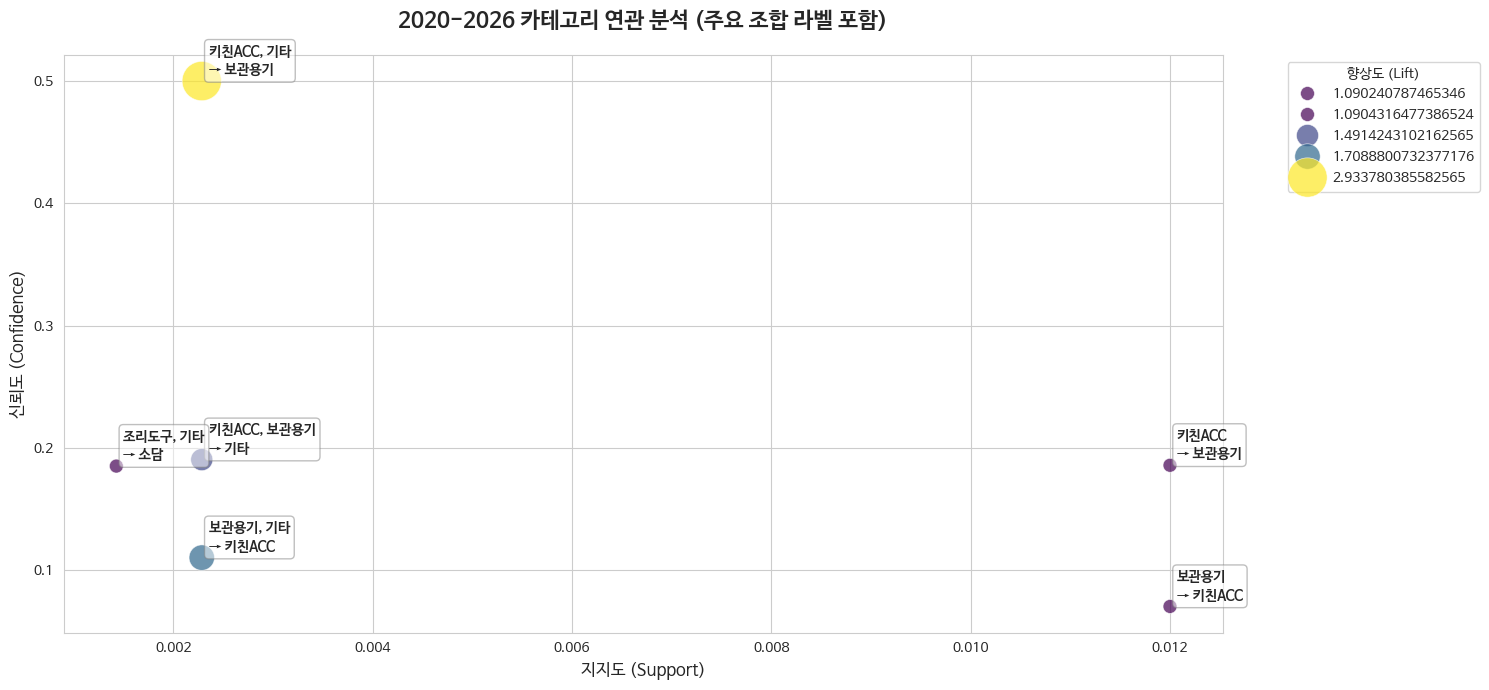

In [44]:
# 1. 의미 있는 규칙만 필터링 (예: 향상도 1 이상, 신뢰도 0.05 이상)

strong_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.05)]
print(f"--- 필터링 후 핵심 규칙 수: {len(strong_rules)}개 ---")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
sns.set_style("whitegrid") # 배경을 더 깔끔하게 설정
plt.rc('font', family='NanumBarunGothic')

# 1. 산점도 그리기 (범례 제목 및 투명도 설정)
scatter = sns.scatterplot(
    data=strong_rules,
    x="support",
    y="confidence",
    size="lift",
    hue="lift",
    palette="viridis",
    sizes=(100, 800), # 점 크기 범위 확대
    alpha=0.7,        # 겹치는 부분 확인을 위한 투명도
    edgecolor="w",    # 점 테두리 흰색으로 구분감 부여
    linewidth=0.5
)

# 2. 상위 규칙에 텍스트 라벨 추가 (향상도 기준 상위 10개)
# 이 부분에서 각 점이 어떤 조합인지 글자를 써줍니다.
top_rules = strong_rules.nlargest(10, 'lift')

for i, row in top_rules.iterrows():
    # 셋(set) 내의 모든 요소를 꺼내서 쉼표로 연결된 문자열로 만듭니다.
    ant = ', '.join(list(row['antecedents']))
    con = ', '.join(list(row['consequents']))
    label = f"{ant}\n→ {con}" # 줄바꿈(\n)을 넣어 라벨이 너무 길어지는 것을 방지

    plt.annotate(
        label,
        xy=(row['support'], row['confidence']),
        xytext=(5, 5), # 글자가 점과 겹치지 않게 살짝 띄움
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5, ec='gray') # 가독성을 위한 배경박스
    )

# 3. 범례 및 타이틀 설정
plt.legend(title='향상도 (Lift)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("2020-2026 카테고리 연관 분석 (주요 조합 라벨 포함)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("지지도 (Support)", fontsize=12)
plt.ylabel("신뢰도 (Confidence)", fontsize=12)

plt.tight_layout()
plt.show()

In [45]:
# 1. 2025-2026년 데이터만 필터링
# 주의: 중복 주문번호가 살아있는(사은품만 제거된) 데이터를 사용해야 합니다.
df_2526 = df_clean[df_clean['연도'].isin(['2025', '2026'])]

# 2. 2025-2026 전용 트랜잭션 행렬(Basket) 생성
basket_2526 = (df_2526.groupby(['주문번호', '상품카테고리'])['수량']
               .sum().unstack().reset_index().fillna(0)
               .set_index('주문번호'))

# 3. 0/1 인코딩
def encode_units(x):
    return 1 if x >= 1 else 0

basket_sets_2526 = basket_2526.applymap(encode_units)

# 4. 분석 진행 (지지도 0.1% 기준)
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets_2526 = apriori(basket_sets_2526, min_support=0.001, use_colnames=True)
rules_2526 = association_rules(frequent_itemsets_2526, metric="lift", min_threshold=1)

# 5. 시각화용 strong_rules 필터링
# 향상도가 1 이상이고 어느 정도 의미 있는 규칙만 남깁니다.
strong_rules_2526 = rules_2526[(rules_2526['lift'] > 1) & (rules_2526['confidence'] > 0.05)]

print(f"✅ 2025-2026 분석 결과 규칙 수: {len(rules_2526)}개")
print(f"✅ 시각화 대상(strong) 규칙 수: {len(strong_rules_2526)}개")

# 결과 상위 10개 확인
display(strong_rules_2526.sort_values('lift', ascending=False).head(10))

✅ 2025-2026 분석 결과 규칙 수: 10개
✅ 시각화 대상(strong) 규칙 수: 6개


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,"(키친ACC, 기타)",(보관용기),0.004314,0.170981,0.002397,0.555556,3.249221,1.0,0.001659,1.865292,0.695234,0.013863,0.463891,0.284787
4,"(보관용기, 기타)",(키친ACC),0.020933,0.063119,0.002397,0.114504,1.814088,1.0,0.001076,1.058029,0.458354,0.029354,0.054846,0.076239
2,"(키친ACC, 보관용기)",(기타),0.011985,0.128955,0.002397,0.200000,1.550929,1.0,0.000851,1.088806,0.359534,0.017301,0.081563,0.109294
1,(보관용기),(키친ACC),0.170981,0.063119,0.011985,0.070093,1.110493,1.0,0.001192,1.007500,0.120021,0.053957,0.007444,0.129983
0,(키친ACC),(보관용기),0.063119,0.170981,0.011985,0.189873,1.110493,1.0,0.001192,1.023320,0.106203,0.053957,0.022789,0.129983
8,"(조리도구, 기타)",(소담),0.007990,0.170502,0.001438,0.180000,1.055708,1.0,0.000076,1.011583,0.053193,0.008123,0.011451,0.094217


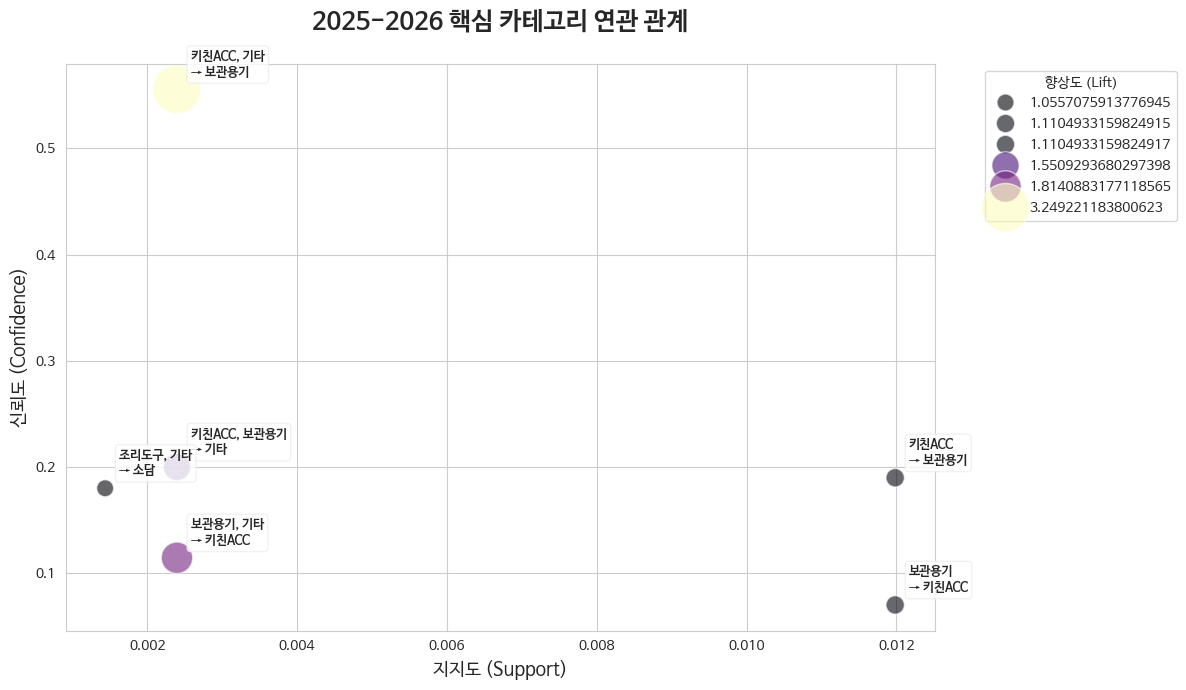

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid") # 배경을 더 깔끔하게 설정
plt.rc('font', family='NanumBarunGothic')

# 산점도 그리기
scatter = sns.scatterplot(
    data=strong_rules_2526,
    x="support",
    y="confidence",
    size="lift",
    hue="lift",
    palette="magma", # 2020-2026 결과와 구분되도록 색상 변경
    sizes=(150, 1200),
    alpha=0.6,
    edgecolor="w"
)

# 라벨 추가 (향상도 기준 상위 15개 추천)
top_labels = strong_rules_2526.nlargest(15, 'lift')

for i, row in top_labels.iterrows():
    ant = ', '.join(list(row['antecedents']))
    con = ', '.join(list(row['consequents']))
    label = f"{ant}\n→ {con}"

    plt.annotate(
        label,
        xy=(row['support'], row['confidence']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8, ec='#eeeeee')
    )

plt.legend(title='향상도 (Lift)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("2025-2026 핵심 카테고리 연관 관계", fontsize=18, fontweight='bold', pad=25)
plt.xlabel("지지도 (Support)", fontsize=13)
plt.ylabel("신뢰도 (Confidence)", fontsize=13)

plt.tight_layout()
plt.show()